In [1]:
import time
import copy
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
from numpy.linalg import eig, eigh
from sklearn.metrics import roc_auc_score, mean_absolute_error, accuracy_score, r2_score
from model_small_node_classification import Specformer
import matplotlib.pyplot as plt

In [2]:
def acc(labels, logits):
    labels = np.array(labels)
    logits = np.array(logits)
    index = logits.argmax(axis=1)
    return accuracy_score(labels, index)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [3]:
torch.cuda.set_device(4)

In [4]:
data_name = 'signal_comb'
e_tensor, u_tensor, x_tensor, y_tensor, m_tensor = torch.load('data/{}.pt'.format(data_name))

In [5]:
e = e_tensor.numpy()
u = u_tensor.numpy()
x = x_tensor.numpy()
y = y_tensor.numpy()

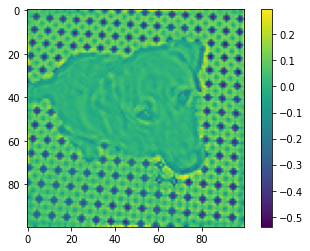

In [6]:
S = np.reshape(y[:, 9], (100,100))
plt.imshow(S.T)
plt.colorbar()
plt.show()

In [22]:
mono_e = mono_poly(comb_mono, e)

In [23]:
mono_y = np.dot(u, mono_e.reshape(-1, 1) * np.dot(u.T, x))

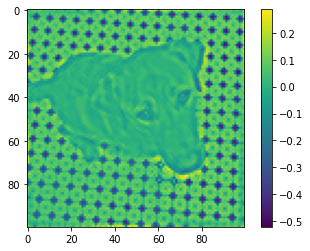

In [24]:
S = np.reshape(mono_y[:, 9], (100,100))
plt.imshow(S.T)
plt.colorbar()
plt.show()

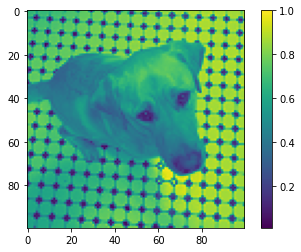

In [14]:
S = np.reshape(x[:, 9], (100,100))
plt.imshow(S.T)
plt.colorbar()
plt.show()

In [18]:
spec_e = torch.load('signal/signal_comb_e1.pt').data.cpu().numpy()

In [19]:
spec_y = np.dot(u, spec_e.reshape(-1, 1) * np.dot(u.T, x))

In [125]:
idx = 19 #19, 28

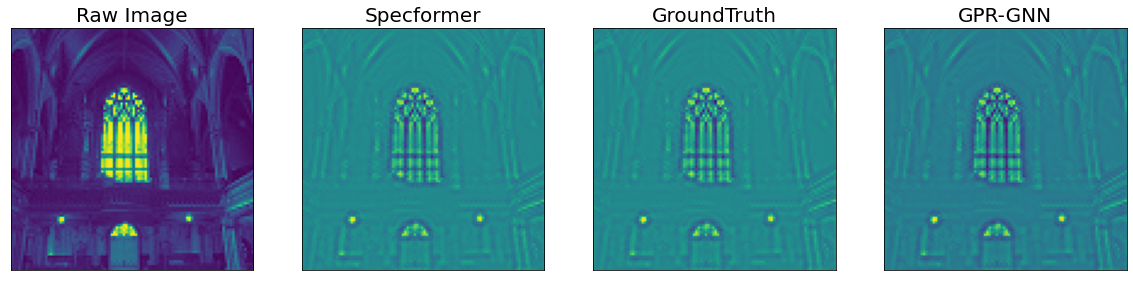

In [126]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 4, 1)
S = np.reshape(x[:, idx], (100,100))
plt.imshow(S.T)
plt.title("Raw Image", size=20)
plt.xticks([])
plt.yticks([])

plt.subplot(1, 4, 2)
S = np.reshape(spec_y[:, idx], (100,100))
plt.imshow(S.T)
plt.title("Specformer", size=20)
plt.xticks([])
plt.yticks([])

plt.subplot(1, 4, 3)
S = np.reshape(y[:, idx], (100,100))
plt.imshow(S.T)
plt.title("GroundTruth", size=20)
plt.xticks([])
plt.yticks([])

plt.subplot(1, 4, 4)
S = np.reshape(mono_y[:, idx], (100,100))
plt.imshow(S.T)
plt.title("GPR-GNN", size=20)
plt.xticks([])
plt.yticks([])

# plt.show()
plt.savefig("spa-19.pdf", dpi=500)

In [5]:
e = e_tensor.cuda()
u = u_tensor.cuda()
x = x_tensor.cuda()
y = y_tensor.cuda()
m = m_tensor.cuda().squeeze()

mask = torch.where(m == 1)

In [6]:
epoch = 2000

nlayer = 1
nfeat = 1
nclass = 1

num_heads = 1
hidden_dim = 16
feat_dropout = 0.0
attn_dropout = 0.0

lr = 1e-2
weight_decay = 0

In [11]:
import model
import importlib
importlib.reload(model)
from model import Specformer

In [12]:
best_r2 = 0
min_loss = float('inf')
counter = 0

ind = 0

def init_params(module):
    if isinstance(module, nn.Linear):
        module.weight.data.normal_(mean=0.0, std=0.01)
        if module.bias is not None:
            module.bias.data.zero_()

net = Specformer(nclass, nfeat, nlayer, hidden_dim, num_heads, feat_dropout, attn_dropout).cuda()
net.apply(init_params)
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
print(count_parameters(net))

best_net = copy.deepcopy(net)

xx = x[:, ind].unsqueeze(1)
yy = y[:, ind]

for idx in range(epoch):

    net.train()
    optimizer.zero_grad()
    logits, new_e, attn, eig = net(e, u, xx)
    logits = logits.squeeze()
    loss = torch.square((logits[mask] - yy[mask])).sum()
    loss.backward()
    optimizer.step()

    r2 = r2_score(yy[mask].data.cpu().numpy(), logits[mask].data.cpu().numpy())
    print(loss.item(), r2)

    if loss.item() < min_loss:
        min_loss = loss.item()
        best_r2 = r2
        best_net = copy.deepcopy(net)
        counter = 0
    else:
        counter += 1
        if counter > 200:
            print(idx, min_loss)
            print(idx, best_r2)
            break

    if idx == epoch - 1:
        print(min_loss)
        print(best_r2)

2084
2969.568115234375 -5.305732416022728
2865.36767578125 -5.084467719616013
2744.26123046875 -4.827304049210107
2601.217041015625 -4.523557129519876
2413.515625 -4.124982320754433
2154.776611328125 -3.575562247119578
1798.78564453125 -2.819633246359343
1333.354736328125 -1.831313624349479
795.1539916992188 -0.6884705512354705
383.87713623046875 0.18485570256476713
666.8941650390625 -0.41611706418361294
932.5234985351562 -0.9801681135146869
646.871826171875 -0.37360074141352095
384.8118896484375 0.18287081671268368
367.9200439453125 0.21873980095849344
467.1980285644531 0.007927869394680598
536.986572265625 -0.14026477656694558
548.0042724609375 -0.16366023380472638
513.0921630859375 -0.08952613059382353
451.4432678222656 0.04138232933987751
384.1427001953125 0.18429175498155026
333.9681091308594 0.2908350779486808
319.93609619140625 0.3206313477451268
342.77996826171875 0.2721235709487584
372.71087646484375 0.20856674084804816
373.9378967285156 0.205961191633232
343.82305908203125 0.

0.5964821577072144 0.9987333993987182
0.5850299596786499 0.9987577173948442
0.5736885070800781 0.998781800423646
0.5626490712165833 0.9988052422526231
0.5521078109741211 0.9988276260822974
0.542212188243866 0.9988486389755402
0.5329821705818176 0.9988682384373583
0.5244005918502808 0.9988864609683021
0.5163794755935669 0.9989034935222639
0.5088581442832947 0.9989194646622409
0.5017564296722412 0.9989345446800749
0.4949822723865509 0.998948929352691
0.48843181133270264 0.9989628389270443
0.4819906949996948 0.9989765163662548
0.47558891773223877 0.9989901101719785
0.46920210123062134 0.9990036722503195
0.46284645795822144 0.9990171682245998
0.4565284252166748 0.9990305842320929
0.4502626955509186 0.9990438892057376
0.44406771659851074 0.9990570438968331
0.4379728436470032 0.9990699860558923
0.432015597820282 0.999082636020459
0.42623239755630493 0.9990949163940369
0.42062145471572876 0.9991068309519155
0.4151807427406311 0.9991183840044279
0.4099045395851135 0.9991295878056204
0.40477588

0.07466048747301102 0.9998414621132623
0.07419879734516144 0.9998424424953548
0.07374145090579987 0.9998434136398682
0.073288694024086 0.999844375038075
0.07284046709537506 0.9998453268321924
0.0723954439163208 0.9998462718320322
0.07195606082677841 0.9998472048351243
0.07151968777179718 0.9998481314449275
0.07108767330646515 0.9998490488092121
0.07065865397453308 0.9998499598069772
0.07023309171199799 0.9998508634690038
0.06981071084737778 0.999851760366538
0.06939190626144409 0.9998526496917878
0.06897589564323425 0.9998535330755686
0.0685635656118393 0.999854408634132
0.06815417855978012 0.9998552779377227
0.06774841248989105 0.9998561395667603
0.06734485924243927 0.9998569964791775
0.06694529950618744 0.999857844942316
0.06654693186283112 0.9998586908374182
0.06615357100963593 0.9998595261314437
0.06576235592365265 0.9998603568653804
0.06537386029958725 0.9998611817979431
0.06498833745718002 0.9998620004524027
0.06460586190223694 0.9998628126230473
0.06422664225101471 0.99986361787

0.024197889491915703 0.9999486169676445
0.024090319871902466 0.9999488453816918
0.023983435705304146 0.999949072346358
0.02387741580605507 0.9999492974783227
0.023771721869707108 0.9999495219139839
0.023667089641094208 0.9999497440939935
0.023562612012028694 0.999949965947047
0.023458775132894516 0.9999501864393082
0.023355837911367416 0.9999504050200383
0.023253578692674637 0.9999506221618375
0.023152263835072517 0.9999508373006785
0.023051399737596512 0.9999510514768005
0.022951681166887283 0.999951263230303
0.022853050380945206 0.9999514726654077
0.022755280137062073 0.9999516802805466
0.022657977417111397 0.9999518868926768
0.022561650723218918 0.9999520914396045
0.022465422749519348 0.9999522957725787
0.022370535880327225 0.9999524972620194
0.022276435047388077 0.9999526970776338
0.022182919085025787 0.9999528956594345
0.022090181708335876 0.999953092579681
0.02199796587228775 0.9999532884002217
0.021906407549977303 0.999953482814616
0.021815162152051926 0.9999536765687207
0.02172

0.011055956594645977 0.9999765232165948
0.011022846214473248 0.9999765935260938
0.010989985428750515 0.9999766633029261
0.010957300662994385 0.9999767327073444
0.01092462707310915 0.9999768020899774
0.010892121121287346 0.9999768711149148
0.010859573259949684 0.999976940229247
0.010827448219060898 0.9999770084427433
0.01079539768397808 0.9999770765003284
0.010763218626379967 0.9999771448343295
0.010731277987360954 0.9999772126577257
0.010699747130274773 0.999977279610676
0.010667894966900349 0.999977347246693
0.010636493563652039 0.9999774139271457
0.01060539111495018 0.999977479972507
0.010574249550700188 0.9999775460994073
0.010543502867221832 0.9999776113858992
0.010512614622712135 0.9999776769781047
0.01048212219029665 0.9999777417275105
0.010451561771333218 0.9999778066209324
0.01042109914124012 0.9999778713062161
0.01039085816591978 0.9999779355209135
0.010360694490373135 0.9999779995729026
0.010330828838050365 0.9999780629908086
0.010300956666469574 0.9999781264238076
0.01027153

0.006229542661458254 0.9999867718709519
0.006213807500898838 0.9999868052846311
0.006198151037096977 0.9999868385301853
0.0061823539435863495 0.9999868720738215
0.006166701205074787 0.999986905311857
0.006151093170046806 0.9999869384539093
0.006135601084679365 0.999986971351532
0.006120121106505394 0.9999870042223786
0.006104730069637299 0.9999870369052611
0.006089375354349613 0.9999870695081435
0.006073916796594858 0.9999871023348738
0.0060587599873542786 0.9999871345195853
0.00604346115142107 0.9999871670062559
0.006028309464454651 0.9999871991793468
0.006013150792568922 0.9999872313685428
0.0059980349615216255 0.9999872634669223
0.005982974544167519 0.9999872954466054
0.00596799049526453 0.9999873272642817
0.005953030660748482 0.9999873590303198
0.005938225891441107 0.9999873904678622
0.005923217628151178 0.9999874223375758
0.005908443126827478 0.9999874537103048
0.005893716122955084 0.9999874849819865
0.005878988653421402 0.9999875162560655
0.005864333361387253 0.9999875473751471
0

0.003825719002634287 0.9999918762730255
0.0038173855282366276 0.9999918939686694
0.0038091959431767464 0.9999919113587483
0.003800930455327034 0.9999919289106529
0.003792832838371396 0.9999919461049768
0.0037846150808036327 0.9999919635551165
0.0037764646112918854 0.9999919808619647
0.003768442664295435 0.9999919978960264
0.0037603219971060753 0.9999920151401812
0.0037522842176258564 0.9999920322081124
0.003744221292436123 0.9999920493294234
0.0037362491711974144 0.9999920662580298
0.0037282879929989576 0.9999920831628665
0.0037202986422926188 0.9999921001282825
0.0037123418878763914 0.9999921170240635
0.0037044137716293335 0.9999921338590163
0.003696517553180456 0.9999921506260405
0.0036887177266180515 0.9999921671884717
0.003680828493088484 0.999992183940991
0.003673007246106863 0.9999922005488572
0.003665258176624775 0.9999922170041244
0.003657432971522212 0.9999922336199076
0.003649691818282008 0.9999922500581814
0.0036419089883565903 0.9999922665843338
0.0036342209205031395 0.9999

0.002520320238545537 0.9999946482233685
0.0025155493058264256 0.9999946583540881
0.0025109085254371166 0.9999946682085427
0.002506314078345895 0.9999946779647534
0.002501531271263957 0.9999946881209911
0.0024969973601400852 0.9999946977482735
0.002492336556315422 0.9999947076451566
0.0024878191761672497 0.9999947172380662
0.0024831765331327915 0.9999947270957331
0.002478537382557988 0.9999947369474248
0.002473996952176094 0.9999947465889658
0.002469422062858939 0.9999947563027743
0.002464825054630637 0.9999947660645349
0.002460214775055647 0.9999947758545898
0.002455636393278837 0.9999947855760105
0.002451105508953333 0.9999947951974968
0.0024466211907565594 0.9999948047198368
0.00244202115572989 0.9999948144876385
0.0024376206565648317 0.9999948238317756
0.0024330979213118553 0.9999948334357699
0.0024286117404699326 0.9999948429617201
0.0024241746868938208 0.9999948523835547
0.0024197297170758247 0.9999948618221657
0.0024152155965566635 0.999994871408059
0.0024108001962304115 0.999994

0.001765373395755887 0.9999962513158185
0.001791480928659439 0.9999961958779852
0.001789643312804401 0.9999961997800143
0.001758440164849162 0.9999962660382451
0.0017471460159868002 0.9999962900209539
0.0017622106242924929 0.9999962580318811
0.0017644725739955902 0.9999962532288555
0.0017445334233343601 0.9999962955683586
0.001732290256768465 0.9999963215665323
0.0017392844893038273 0.9999963067146804
0.0017428719438612461 0.9999962990967964
0.001730707474052906 0.9999963249274295
0.0017189036589115858 0.9999963499925283
0.0017202035523951054 0.9999963472317672
0.001723571214824915 0.999996340080938
0.0017167795449495316 0.9999963545026759
0.0017066749278455973 0.9999963759593942
0.0017041100654751062 0.9999963814056626
0.0017058501252904534 0.9999963777106058
0.0017024801345542073 0.9999963848667626
0.0016945694806054235 0.9999964016647076
0.0016900016926229 0.9999964113639461
0.0016898397589102387 0.9999964117078747
0.001688174670562148 0.999996415243703
0.0016826086211949587 0.99999

0.0012299948139116168 0.9999973881661618
0.0012280293740332127 0.9999973923396288
0.0012261074734851718 0.9999973964209046
0.0012241504155099392 0.9999974005764876
0.0012222927762195468 0.9999974045211764
0.0012203826336190104 0.9999974085771771
0.001218461082316935 0.9999974126574298
0.0012165631633251905 0.9999974166877372
0.0012146496446803212 0.9999974207507916
0.0012128306552767754 0.9999974246135097
0.0012109013041481376 0.9999974287103942
0.0012090009404346347 0.9999974327457712
0.0012071363162249327 0.9999974367051232
0.00120526272803545 0.9999974406834607
0.0012034462997689843 0.9999974445407107
0.0012015497777611017 0.9999974485677949
0.0011996811954304576 0.9999974525357275
0.0011977822287008166 0.9999974565680919
0.0011959297116845846 0.9999974605018362
0.0011940605472773314 0.9999974644708812
0.001192243304103613 0.9999974683298397
0.001190385315567255 0.9999974722751621
0.0011885360581800342 0.9999974762019982
0.0011866550194099545 0.9999974801960443
0.0011848278809338808

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

In [31]:
logits, new_e, attn, eig = best_net(e, u, xx)

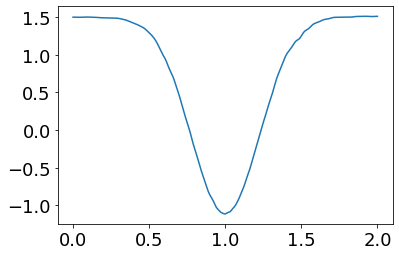

In [32]:
plt.plot(e.data.cpu(), new_e.data.cpu())

In [512]:
def condense(matrix, eig, size=10, mode='freq'):
    n = eig.shape[0]
    col_sum = np.zeros((n, size))
    dense = np.zeros((size,size))
    per_freq = 2 / size
    per_number = n // size
    binning = []
    
    if mode == 'freq':
        axis = [0]
        for i in range(1, size): # 1,2,...,9
            axis.append(np.where(eig > per_freq * i)[0][0])
        axis.append(n-1)
        binning = [axis[i+1]-axis[i] for i in range(size)]
        print('number binning:', binning)
    else:
        axis = [i * per_number for i in range(0, size)]
        axis.append(n-1)
        binning = [eig[axis[i+1]]-eig[axis[i]] for i in range(size)]
        print('frequency binning:', binning)
        axis.append(n-1)
        
    for col in range(size):
        col_sum[:, col] = matrix[:, axis[col]:axis[col+1]].sum(axis=1)
        
    for row in range(size):
        dense[row, :] = col_sum[axis[row]:axis[row+1], :].mean(axis=0)

    return dense, binning

In [513]:
dense, binning = condense(attn.data.cpu().numpy(), e.data.cpu().numpy(), size=9, mode='number')

frequency binning: [0.31416985, 0.26513228, 0.21113461, 0.1574611, 0.10420436, 0.15746105, 0.21113467, 0.2651322, 0.31416988]


In [15]:
import cmocean
import seaborn as sns
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [1]:
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)

img = eig[:16, :].data.cpu().numpy()

# cmap = ListedColormap(sns.color_palette('Blues'))
cmap = sns.color_palette("light:#5A9", as_cmap=True)

fig, ax = plt.subplots()
im = ax.imshow(img, cmap=cmap)
ax.set_title('Dependence')
ax.axvline(2.5, linestyle='-', c='white', linewidth=2)
ax.axvline(5.5, linestyle='-', c='white', linewidth=2)
ax.axhline(2.5, linestyle='-', c='white', linewidth=2)
ax.axhline(5.5, linestyle='-', c='white', linewidth=2)
# ax.axhline(groundtruth[1], linestyle='-', c='r', linewidth=2)
# ax.set_xlabel("$v_x$")
# ax.set_ylabel("$v_y$")

cbar = fig.colorbar(im)
cbar.locator = ticker.MaxNLocator(nbins=7)  # colorbar上的刻度值个数
cbar.update_ticks()

# cbar.ax.set_yticklabels([''])
# cbar.ax.set_ylabel('Dependence')

# labellist = ['', 'Low', '', '', 'Medium', '', '', 'High', '']
# ax.set_xticks(ticks = [i for i in range(9)], labels = labellist, rotation = 'horizontal')
# ax.set_yticks(ticks = [i for i in range(9)], labels = labellist, rotation = 'horizontal')

# for i in range(9):
#     for j in range(9):
#         text = ax.text(j, i, np.round(dense[i, j], 2), ha="center", va="center", color="black", size=8)

fig.tight_layout()
# fig.savefig('high.pdf', transparent=True, bbox_inches='tight', pad_inches=0)
# plt.close()
plt.show()

NameError: name 'matplotlib' is not defined

In [516]:
fig.savefig('high.pdf', transparent=True, bbox_inches='tight', pad_inches=0)
plt.close()

In [ ]:
for ind in range(50):
    
    best_r2 = 0
    min_loss = float('inf')
    counter = 0
    
    net = SpectralTransformer(nclass, nfeat, nlayer, hidden_dim, num_heads, feat_dropout, attn_dropout).cuda()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    print(count_parameters(net))
    
    xx = x[:, ind].unsqueeze(1)
    yy = y[:, ind]
    
    for idx in range(epoch):

        net.train()
        optimizer.zero_grad()
        logits = net(e, u, xx).squeeze()
        loss = torch.square((logits[mask] - yy[mask])).sum()
        loss.backward()
        optimizer.step()
        
        r2 = r2_score(yy[mask].data.cpu().numpy(), logits[mask].data.cpu().numpy())
        print(loss.item(), r2)
        
        if loss.item() < min_loss:
            min_loss = loss.item()
            best_r2 = r2
            counter = 0
        else:
            counter += 1
            if counter > 100:
                print(idx, min_loss)
                print(idx, best_r2)
                break
                
        if idx == epoch - 1:
            print(idx, min_loss)
            print(idx, best_r2)


In [1]:
import torch
import numpy as np
from scipy.special import comb
import matplotlib.pyplot as plt

In [2]:
e = np.load('signal/signal_e.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'signal/signal_e.npy'

In [7]:
low_mono = [1.0017, -2.0371,  0.4280,  0.5928,  0.1647, -0.0654, -0.0988, -0.0493, 0.0042,  0.0235, -0.0041]
low_cheb = [0.2440, -0.4044,  0.3037, -0.1205,  0.0334,  0.0506, -0.0302,  0.0344, 0.0036,  0.0031,  0.0086]
low_bern = [0.9999,  1.0796, -0.4880, -0.2422,  0.1222,  0.1494, -0.0171, -0.1101, -0.0108,  0.0750, -0.0252]

high_mono = [2.0735e-04,  1.5226e+00, -1.5276e-02, -2.1381e-01, -1.4762e-01, -6.4357e-02, -9.9193e-03,  1.5550e-02,  1.9932e-02,  1.0518e-02, -7.3813e-03]
high_cheb = [7.8421e-01,  4.6114e-01, -2.4732e-01,  1.7546e-01,  1.8557e-02, -2.3387e-03,  7.3245e-02,  2.6562e-03,  2.4639e-02,  1.6257e-02, -1.3716e-04]
high_bern = [7.1440e-05, -4.8892e-02,  1.2635e+00,  1.8377e+00,  2.4924e-01, 7.2417e-01,  1.9766e+00,  2.0058e-01,  1.3083e+00,  9.5113e-01, 1.0006e+00]

band_mono = [-3.3344e-04, -1.8902e-01,  1.1887e+00,  3.4764e-01, -1.6448e-01, -2.6296e-01, -1.6750e-01, -3.8750e-02,  4.3490e-02,  5.1235e-02, -1.6844e-02]
band_cheb = [0.2073,  0.0468, -0.2821,  0.0455,  0.2805,  0.0398, -0.1034,  0.0310, 0.0965,  0.0177, -0.0181]
band_bern = [1.4971e-04, -7.3908e-02,  5.5450e-01, -1.1454e+00, -4.5522e-01, 4.4627e+00,  1.8949e+00, -3.0572e+00,  8.0376e-01,  2.3294e-01, -1.0389e-01]

rej_mono = [1.0011, -0.4344, -0.2086, -0.0694, -0.0016,  0.0248,  0.0295,  0.0238, 0.0139,  0.0027, -0.0083]
rej_cheb = [0.8495,  0.0671,  0.3951,  0.0644, -0.1766,  0.0565,  0.1892,  0.0430, -0.0401,  0.0210,  0.0350]
rej_bern = [1.0007,  1.0229,  0.5839,  2.4577, -0.1656, -1.4211, -0.8317,  1.3677, 3.0041, -0.4481,  1.2971]

comb_mono = [-6.9901e-04,  4.0126e+00, -4.0277e+00, -1.3519e+00,  5.3646e-01, 9.0141e-01,  5.3290e-01,  5.2692e-02, -2.2960e-01, -2.1108e-01, 1.0506e-01]
comb_cheb = [0.5376,  0.0441, -0.2526,  0.0429, -0.3030,  0.0374,  0.2064,  0.0278, -0.0722,  0.0092,  0.0455]
comb_bern = [-3.2221e-04,  8.1571e-01,  9.6699e-02,  3.8612e+00,  4.8130e-01, -2.9997e+00, -9.5402e-01,  4.7486e+00,  3.4929e-01,  4.2680e-01, 9.7782e-02]

In [8]:
def mono_poly(para, e):
    z = np.zeros(e.shape[0])
    for i in range(len(para)):
        z += para[i] * e**i
    return z

def cheb_poly(para, e):
    e = e - 1.
    T_k_2, T_k_1 = np.ones(e.shape[0]), e
    Z = para[0] * T_k_2
    for i in range(10):
        T_k_2, T_k_1 = T_k_1, 2 * e * T_k_1 - T_k_2
        Z = Z + para[i+1] * T_k_2
    return Z

def bern_poly(para, e):
    e1 = e
    e2 = 2*np.ones(e.shape[0]) - e
    
    e_ = np.ones(e.shape[0])
    cache = [e_]
    for _ in range(10):
        e_ = e2 * e_
        cache.append(e_)

    z = (comb(10, 0) / (2**10)) * para[0] * cache[10]
    for i in range(10):
        e_ = cache[10-i-1]
        for _ in range(i+1):
            e_ = e1 * e_
        z = z + (comb(10, i+1) / (2**10)) * para[i+1] * e_
        
    return z

In [28]:
mono_e = mono_poly(high_mono, e)
cheb_e = cheb_poly(high_cheb, e)
bern_e = bern_poly(high_bern, e)

In [15]:
spec_e = torch.load('signal/signal_comb_e1.pt').data.cpu().numpy()

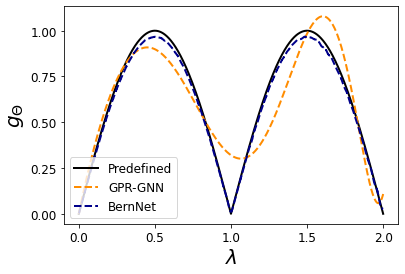

In [48]:
plt.plot(e, np.abs(np.sin(np.pi * e)), linestyle='-', color='black', linewidth=2)
# plt.plot(e, 1. - np.exp(-10 * (e - 1) ** 2), linestyle='-', color='black', linewidth=2)
# plt.plot(e, 1. - np.exp(-10 * e ** 2), linestyle='-', color='black', linewidth=2)

plt.plot(e, mono_e, linestyle='--', color='darkorange', linewidth=2)
# plt.plot(e, cheb_e, linestyle='-', color='blue', linewidth=2)
# plt.plot(e, bern_e, linestyle='--', color='darkgreen', linewidth=2)
plt.plot(e, spec_e, linestyle='--', color='darkblue', linewidth=2)

# "blue" "red" "darkgreen" "blueviolet" "darkorange"

plt.legend(['Predefined', 'GPR-GNN', 'BernNet', 'Specformer'], loc='lower left', prop={'size': 12, "family" : "Times New Roman"})

plt.xlabel('$\lambda$', fontdict={'size': 20})
plt.ylabel('$g_{\Theta}$', fontdict={'size': 20})
plt.xticks(size=12)
plt.yticks(size=12)
plt.xticks([0.0, 0.5, 1, 1.5, 2.0])
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0])

plt.show()

# 1. - np.exp(-10 * (e-1)**2)
# np.abs(np.sin(np.pi * e))